## Problem set 5: Cosmic Microwave Background
## 1)

Chi squared for initial values of parameters is  15267.937150261656  for  2501  degrees of freedom.


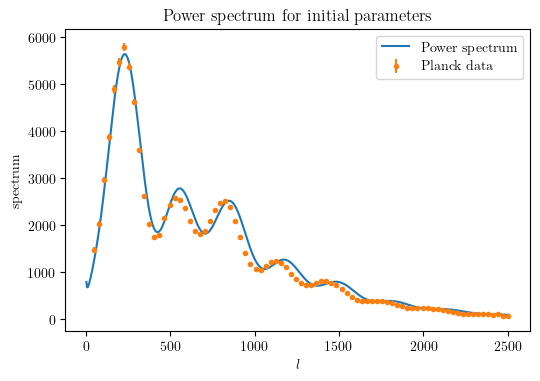

Chi squared for new parameter is  3272.205355920218  for  2501  degrees of freedom.


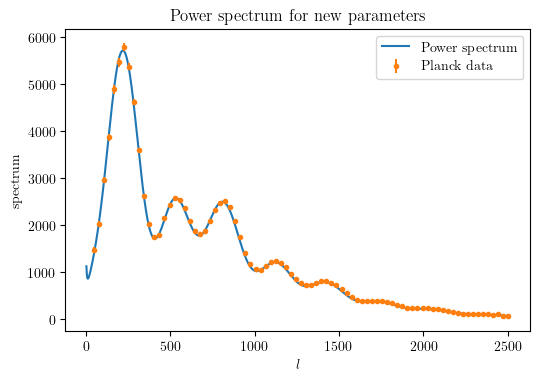

In [6]:
import numpy as np
import camb
from matplotlib import pyplot as plt
import time
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.dpi'] = 100

# pset 5
# 1)

# calculate model power spectra from parameters
def get_spectrum(pars,lmax=3000):
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]
    return tt[2:]

# parameters dialed into script
pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])

# CMB data from Planck satellite
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0] # multipole, starting with l=2
spec=planck[:,1] # variance of sky as a function of multipole
errs=0.5*(planck[:,2]+planck[:,3]) # error: average of upper/lower 1 sigma uncertainty
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("Chi squared for initial values of parameters is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model,label='Power spectrum')
plt.title('Power spectrum for initial parameters')
plt.xlabel('$l$')
plt.ylabel('spectrum')
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.',label='Planck data')
plt.legend()
plt.show()

# new parameters 
pars=np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95])
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("Chi squared for new parameter is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
plt.clf()
plt.plot(ell,model, label='Power spectrum')
plt.title('Power spectrum for new parameters')
plt.xlabel('$l$')
plt.ylabel('spectrum')
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.',label = 'Planck data')
plt.legend()
plt.show()

 The mean and variance for $\chi^2$ is $n$ and $2n$ respectively, where $n$ is the degree of freedom. Since we have 2501 degrees of freedom, we expect a chi squared with mean $\mu=2501$ ($\mu=n$) and standard deviation $\sigma=70.72$ ($\sigma=\sqrt{2n}$). The $\chi^2$ value for the parameters dialed into the test script is 15267.937150261656. This is incredibly high, it is absolutely not within 1 $\sigma$ of the mean (it's within 181 $\sigma$ though!).

 The $\chi^2$ for the new parameters is 3272.205355920218. This much better than before, but still not within 1 $\sigma$ of the mean (it's within 11 $\sigma$). None of these fits are acceptable.

 ## 2) Levenberg-Marquardt to find best fit parameters

In [8]:
# function to take the derivative  
def centered_derivative(params,i):
    # some arbitrary dx; will not really be optimal
    dx=1e-9
    params_left=params.copy();params_right=params.copy()
    params_right[i]+=dx
    params_left[i]-=dx
    # two points centered derivative
    d=0.5*(get_spectrum(params_right)-get_spectrum(params_left))/(dx)
    return d

# function to take derivative with respect to all parameters
def derivative(params):
    grad = np.zeros([model.size, params.size])
    for i in range(params.size):
        temp=centered_derivative(params,i)
        temp=temp[:len(planck[:,0])]
        grad[:,i]=temp
    return grad

# inital guess are the params from 1) 
params=np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95])
error=0.5*(planck[:,2]+planck[:,3])         

# levenberg-marquardt method to find best fit parameters
t=2 # levenberg-marquardt parameter
d=get_spectrum(params)
d=d[:len(planck[:,0])]
r=planck[:,1]-model
chisq=np.sum((r/error)**2)

# let's do 70 iterations for fun
for i in range(70):
    grad=derivative(params)
    grad=grad[:len(planck[:,0])]
    r=planck[:,1]-d
    lhs = grad.T@grad
    lhs = lhs + t*np.diag(np.diag(lhs))
    rhs = grad.T@r
    # shift in parameters
    dp = np.linalg.inv(lhs)@rhs
    params_new = params+dp

    # calculate new chi squared with these new 'trial' parameters    
    d=get_spectrum(params_new)
    d=d[:len(planck[:,0])]
    r=planck[:,1]-d
    chisq_trial=np.sum((r/error)**2)
        
    # keep the trial parameters if new chi squared is better 
    # reduce levenberg-marquardt parameter
    if chisq_trial<chisq:
        t=t/2
        if t<0.2:
            t=0
        params=params_new
        chisq = chisq_trial
    
    # if new chi squared is worse, don't take new parameters
    # make levenberg-marquardt parameter bigger
    if chisq_trial>chisq:
        if t==0:
            t=2
        else: 
            t=t*3
       
pred=get_spectrum(params)
pred=pred[:len(planck[:,0])]  
grad=derivative(params)
N=np.mean((planck[:,1]-pred)**2)
Ninv=1/N
covariance=np.linalg.inv(Ninv*grad.T@grad) # covariance matrix
params_err=np.sqrt(np.diag(covariance)) # error on parameters

Chi squared for best fit parameters is  2582.15066327397  for  2501  degrees of freedom.


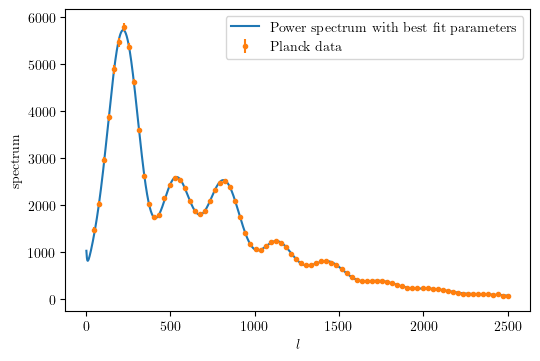

In [12]:
# writing best fit parameters and errors in 'planck_fit_params.txt'
lines = ['Best fit parameters with error are:', 
'H0= '+str(params[0])+' with error of '+str(params_err[0]),
'omb= '+str(params[1])+' with error of '+str(params_err[1]),
'omc= '+str(params[2])+' with error of '+str(params_err[2]),
'tau= '+str(params[3])+' with error of '+str(params_err[3]),
'As= '+str(params[4])+' with error of '+str(params_err[4]),
'ns= '+str(params[5])+' with error of '+str(params_err[5])]
with open('planck_fit_params.txt','w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

# plotting stuff, look at the txt file for the values!
print("Chi squared for best fit parameters is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
plt.plot(planck[:,0],pred, label='Power spectrum with best fit parameters from Levenberg-Marqardt')
plt.xlabel('$l$')
plt.ylabel('spectrum')
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.',label = 'Planck data')
plt.legend()
plt.show()

$\chi^2$ for fit with best parameters obtained with Levenberg-Marquardt is 2582.15066327397. This is pretty good, as it is within 2 $\sigma$ of the mean $\chi^2$

## 3) Markov Chain Monte Carlo to find best fit parameters

In [ ]:
# 3) MCMC

# function to calculate the chi squared during the chain
def get_chisq(params):
    d=get_spectrum(params)
    d=d[:len(planck[:,0])]
    r=planck[:,1]-d
    chisq=np.sum((r/error)**2)
    return chisq

# Markov Chain Monte Carlo
def run_mcmc(params,n=5000):
    chain=np.zeros([n,len(params)])
    chivec=np.zeros(n)

    # chi squared at current location
    chi=get_chisq(params)
    for i in range(n):
        # trial parameter, use covariance matrix from 2) to get new trial parameters
        params_trial=np.random.multivariate_normal(params,covariance)
        # chi squared with trial parameters
        chi_trial=get_chisq(params_trial)
        # probability of accepting step
        accept_prob=np.exp(-0.5*(chi_trial-chi))
        if np.random.rand(1)<accept_prob: # accept step with appropriate probability
            params=params_trial
            chi=chi_trial
        chain[i,:]=params
        chivec[i]=chi
    return chain,chivec

# same guess for params as 2)
params=np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95])
# let's do 5000 steps!      
chain,chivec=run_mcmc(params,5000)

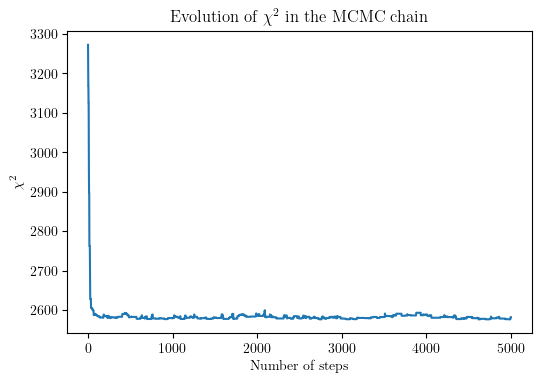

In [55]:
# check if chain converged
plt.plot(chivec)
plt.xlabel('Number of steps')
plt.ylabel('$\chi^2$')
plt.title('Evolution of $\chi^2$ in the MCMC chain')
plt.show()

Based on the plot above, the chain clearly converged to some value of $\chi^2$ after a very little amount of steps, after which $\chi^2$ just oscillates a little around that value. Because of this oscillation, what I'll do is pick out the smallest $\chi^2$ the chain outputted and get the parameters associated to that step. These will be my best fit parameters for the chain.

Best fit parameters using MCMC are:  [6.89661801e+01 2.25618488e-02 1.16354494e-01 9.69329436e-02
 2.26412716e-09 9.76234731e-01]
best fit chisq using MCMC is:  2576.9639845303773


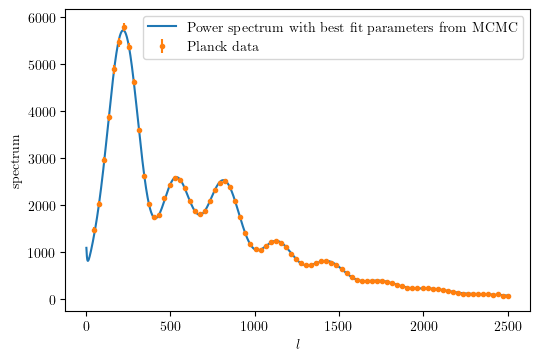

In [61]:
# chi squared oscillates after chain converged
# so just pick the smallest chi squared and the parameters associated to it
a=np.where(chivec==np.min(chivec))
chisq_mcmc=chivec[a[0][0]] # best fit chisq
params_mcmc=chain[a[0][0]] # best fit params

# getting covariance matrix and error on params from mcmc chain
pred=get_spectrum(params_mcmc)
pred=pred[:len(planck[:,0])]  
grad=derivative(params_mcmc)
N=np.mean((planck[:,1]-pred)**2)
Ninv=1/N
covariance=np.linalg.inv(Ninv*grad.T@grad) # covariance matrix
params_err=np.sqrt(np.diag(covariance)) # error on parameters

# saving chain in 'planck_chain.txt', first column is the chisquared
# other columns are parameters in order
lines=np.empty([len(chain),7])
lines[:,0]=chivec
lines[:,1]=chain[:,0]
lines[:,2]=chain[:,1]
lines[:,3]=chain[:,2]
lines[:,4]=chain[:,3]
lines[:,5]=chain[:,4]
lines[:,6]=chain[:,5]
np.savetxt('planck_chain.txt',lines)
print('Best fit parameters using MCMC are: ',params_mcmc)
print('best fit chisq using MCMC is: ', chisq_mcmc)
# plotting stuff
plt.plot(planck[:,0],pred, label='Power spectrum with best fit parameters from MCMC')
plt.xlabel('$l$')
plt.ylabel('spectrum')
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.',label = 'Planck data')
plt.legend()
plt.show()

$\chi^2$ is now 2576.9639845303773. This is better than what I got from running the Levenberg-Marqardt fit (I should hope so because the MCMC chain took several hours to run). However, this is still not within 1 $\sigma$ of the mean value of $\chi^2$ $(2510\pm70.72)$. It is within 2 $\sigma$ though, not bad.

Estimating the mean value of the dark energy $\Omega_\Lambda$, using $\Omega_b+\Omega_c+\Omega_\Lambda=1$.

In [64]:
# finding the mean value of the dark energy using parameters found with mcmc
omb=(100**2*params_mcmc[1])/(params_mcmc[0])**2
omc=(100**2*params_mcmc[2])/(params_mcmc[0])**2
oml=1-omb-omc

# do some error propagation to find error on mean dark energy
omb_error=omb*np.sqrt((params_err[0]/params_mcmc[0])**2+(params_err[1]/params_mcmc[1])**2)
omc_error=omc*np.sqrt((params_err[0]/params_mcmc[0])**2+(params_err[2]/params_mcmc[2])**2)
oml_error=oml*np.sqrt((omb_error/omb)**2+(omc_error/omc)**2)

print('My estimate of the mean value of the dark energy is: ',oml, 'with uncertainty of: ',oml_error)

My estimate of the mean value of the dark energy is:  0.7079340035099035 with uncertainty of:  0.011418849435390723


## 4) Markov Chain Monte Carlo with fixed tau

Use the same mcmc as in 3) but this time we have a fixed tau with fixed value of $0.0540\pm0.0074$. This means that every step of the chain, I need to fix the value of tau to some value taken from a univariate gaussian distribution with mean 0.0540 and standard deviation 0.0074. This can be done using `np.random.normal(mean,std)`.

In [66]:

# Markov Chain Monte Carlo with fixed tau
def run_mcmc_fixed_tau(params,n=5000):
    chain=np.zeros([n,len(params)])
    chivec=np.zeros(n)

    # chi squared at current location
    chi=get_chisq(params)
    for i in range(n):
        # trial parameter, use covariance matrix from 2) to get new trial parameters
        params_trial=np.random.multivariate_normal(params,covariance)
        # fixed tau
        params_trial[3]=np.random.normal(0.0540,0.0074)
        # chi squared with trial parameters
        chi_trial=get_chisq(params_trial)
        # probability of accepting step
        accept_prob=np.exp(-0.5*(chi_trial-chi))
        if np.random.rand(1)<accept_prob: # accept step with appropriate probability
            params=params_trial
            chi=chi_trial
        chain[i,:]=params
        chivec[i]=chi
    return chain,chivec

# same guess for params as 3) but with the appropriate value of tau
params=np.asarray([69,0.022,0.12,0.0540,2.1e-9,0.95])

# let's do 5000 steps again
chain_fixed,chivec_fixed=run_mcmc_fixed_tau(params,n=5000)

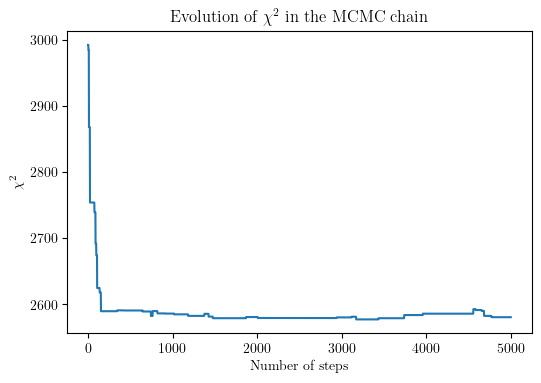

In [67]:
# check if chain converged
plt.plot(chivec_fixed)
plt.xlabel('Number of steps')
plt.ylabel('$\chi^2$')
plt.title('Evolution of $\chi^2$ in the MCMC chain')
plt.show()

Chain converged pretty fast again. Same thing here, I'll pick the smallest $\chi^2$ and the parameters associated to it as the best fit parameters.

Best fit parameters using MCMC with tau prior are:  [6.78827422e+01 2.23749836e-02 1.18708926e-01 5.71353128e-02
 2.10281184e-09 9.70503772e-01]
best fit chisq using MCMC with tau prior is:  2577.270677067728


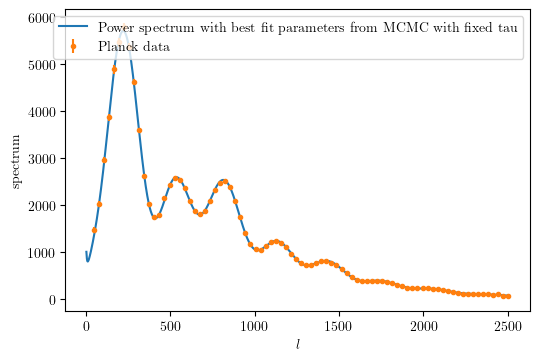

In [83]:
# chi squared oscillates after chain converged
# so just pick the smallest chi squared and the parameters associated to it
a=np.where(chivec_fixed==np.min(chivec_fixed))
chisq_mcmc_fixed=chivec_fixed[a[0][0]] # best fit chisq
params_mcmc_fixed=chain_fixed[a[0][0]] # best fit params
# saving chain in 'planck_chain_tauprior.txt', first column is the chisquared
# other columns are parameters in order
lines=np.empty([len(chain),7])
lines[:,0]=chivec_fixed
lines[:,1]=chain_fixed[:,0]
lines[:,2]=chain_fixed[:,1]
lines[:,3]=chain_fixed[:,2]
lines[:,4]=chain_fixed[:,3]
lines[:,5]=chain_fixed[:,4]
lines[:,6]=chain_fixed[:,5]
np.savetxt('planck_chain_tauprior.txt',lines)
print('Best fit parameters using MCMC with tau prior are: ',params_mcmc_fixed)
print('best fit chisq using MCMC with tau prior is: ', chisq_mcmc_fixed)

temp=get_spectrum(params_mcmc_fixed)
temp=temp[:len(planck[:,0])]

plt.plot(planck[:,0],temp, label='Power spectrum with best fit parameters from MCMC with fixed tau')
plt.xlabel('$l$')
plt.ylabel('spectrum')
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.',label = 'Planck data')
plt.legend()
plt.show()

In [84]:
# let's compare those results to what I get from importance sampling my chain from problem 3

def fixed_chisq(params,params_fixed,errs):
    return np.sum(((params-params_fixed)/errs)**2)

expected_params=np.zeros(params.size)
expected_params[3]=0.0540
expected_errs=1e20*np.ones(params.size)
expected_errs[3]=0.0074

# chi squared vector from importance sampling
importance_chivec=np.zeros(np.size(chivec))
for i in range(np.size(chivec)):
    chi=fixed_chisq(chain[i,:],expected_params,expected_errs)
importance_chivec=importance_chivec-importance_chivec.mean()
# weights
w=np.exp(0.5*importance_chivec)

# parameters from importance sampling
importance_params=np.zeros(params.size)
for i in range(params.size):
    importance_params[i]=np.sum(w*chain[:,i])/np.sum(w)

print('Chi squared from importance sampling my MCMC chain from problem 3 is: ', get_chisq(importance_params))
print('Chi squared from running a MCMC with fixed tau is (problem 4) is: ', get_chisq(params_mcmc_fixed))


Chi squared from importance sampling my MCMC chain from problem 3 is:  2577.9705341706585
Chi squared from running a MCMC with fixed tau is (problem 4) is:  2577.270677067728


$\chi^2$ is similar but slightly higher when importance sampling my chain from problem 3). However neither of those $\chi^2$ fall within 1 $\sigma$ of 2501.